# 3' Rapid Amplification of cDNA Ends (RACE) of human telomerase (hTR) gene Analysis
    author: Morgan R Weichert
    email: morganrweichert@gmail.com

###### Input dataset 

| Data         | Location                                       | Type   | Read Length | Lanes|
|-------------------|------------------------------------------------|--------|-------------|----|
| Seqence directory | /path/to/raw/data/| Paried |         RapidSeq-250 |2|

> The amplicons contain (from 5' to 3'):
- 10 nt Molecular Barcode: NNNNNNNNNN
    - barcode is for removing PCR duplicates/bias
- hTR-specific primer: CAGGAAGAGGAACGGAGCGAGT
- hTR insert sequence (variable ending position): CCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC
- ntna (non-templated nucleotide addition) sequence: variable length & sequence
    - ntna sequence includes polyA tails or any other sequence that is not the reference hTR sequence
- linker (adaptor) sequence: TTTAACCGCGAATTCCAG
    - the linker seq will be variable length depending on how long the hTR sequence is and how long the ntna sequence is
- AC-index
- P7 Adapter: ATCTCGTATGCCGTCTTCTGCTTG

###### import python packages

In [1]:
import os
import re
import gzip
import regex
import commands
import subprocess
import numpy as np
import pandas as pd
from Bio import Seq
from Bio import SeqIO
from collections import Counter

## raw reads to analysis ready reads

### create symbolic links to raw data
this saves space by pointing to the raw fastq files so that I don't need to copy them into my own directory

In [ ]:
# %load /home/msr/general_scripts/create_symlinks_to_data.R
#!/n/apps/CentOS7/bin/Rscript

#################################################################################################
# R script for matching fastq names from machine (s_lane_read_index.fastq) 
# to the sample name given in the sample report (control_1) 
# and creates raw_data directory containing symbolic links to the renamed fastq files.
# The symbolic linked fastq files have renamed format samplename_lane_read.fastq

# This script is to be ran on the command line giving a directory to the raw data
# Example: $ create_symlinks_to_data.R /path/to/raw/data/
# This script also assumes there is a SampleReport.csv file in the given directory
# containg a column 'Output' and a column 'SampleNames'
#################################################################################################

args = commandArgs(trailingOnly = TRUE) # script expects arguments trailing
fc.dir <- args[1] # the first argument is the flowcell directory

################ parse sample report ############################################################
molng <- unlist(strsplit(fc.dir, '/'))[6] # this is the sequenced order ID

fqs <- list.files(fc.dir, "[ACGT].+\\.fastq\\.gz", full = TRUE) # list of the fastq files
#print(length(fqs)) # check number of samples matches

report <- read.csv(list.files(fc.dir, "Report\\.csv", full = TRUE)) # read in the SampleReport.csv
# subset the sample report to ony this sqeuencing order
# this is required because sometime multipe separate orders are sequenced together
report <- subset(report, report$Order == molng) 
#print(unique(report$SampleName)) # if you want to check the sample names

# match the sample name (control_1) to the machine name (s_lane_read_index)
samples <- as.character(report$SampleName[match(basename(fqs), report$Output)]) 
#print(unique(samples)) # check matching correctly

lanes <- as.character(report$Lane[match(basename(fqs), report$Output)]) # grab the corresponding lane
read <- as.character(report$Read[match(basename(fqs), report$Output)]) # grab the corresponding read 
                                                                      # (1 fw read, 2 rev read)
#####################################################################################################

# create file paths with new name format sample_lane_read
links <- file.path("raw_data",
                   paste0(paste(samples,lanes,read,sep="_"),".fastq.gz"))
# print(links) # check this works

####### create raw_data direcotry with create symlinks ################
dir.create("raw_data",FALSE,TRUE) # give FALSE if file alread exists    
file.symlink(fqs,links)
warnings()
#####################################################################################################


In [ ]:
%%bash 

create_symlinks_to_data.R /path/to/raw/data/

### Raw Read Counts per Sample

In [ ]:
# %load /home/msr/general_scripts/count_reads_per_sample.py
#!/home/msr/bin/anaconda/bin/python

"""
python script for counting reads in fastq file
run on command line and specify (1) directory of fastq files and (2) output tsv file name
assumes sample naming convention of samplename_lane_read.fastq.gz
Example: 
$ count_number_single_reads_per_sample.py -indir ./raw_data/ -outfile raw_read_counts_per_sample.tsv
"""

import os
import re
import argparse
import commands
import pandas as pd

################################ set up user input ##############################################
parser = argparse.ArgumentParser(
    description='Count number of reads for each file in dir')
# define arguments
parser.add_argument('-indir', type=str, required=True,
                    help='input directory of gzipped fastq files')
parser.add_argument('-outfile', type=str, required=True,
                    help='path to tsv output file')
args = parser.parse_args()
#################################################################################################

df = pd.DataFrame()  # initialize dataframe

#################################################################################################
for i in os.listdir(args.indir): # for each file (i) in the given directory
    
    # here samples are named samplename_lane_read.fastq.gz
    sample_name = re.split(r'_([0-9])_([0-9]).fastq', i)[0]  # grap sample name
    read = re.split('_', re.split(r'.fastq', i)[0])[-1]  # grab read numberv(1=fw, 2=rev)
    lane = re.split('_', re.split(r'.fastq', i)[0])[-2]  # grab lane number

    # unix to count num lines in file
    lane_lines = commands.getoutput('zcat ' + args.indir + i + '| wc -l')
    # divide by 4 for to get number of reads for fastq files
    lane_reads = int(lane_lines) / 4.0

    # store in dataframe
    df = df.append({'lane_read': str('lane_' + lane + '_read_' + read),
                    'read_count': lane_reads,
                    'sample': sample_name},
                    ignore_index = True)

#################################################################################################

# reorganize dataframe
df = df.pivot_table(values  = 'read_count',
                    index   = ["sample"],
                    columns = ['lane_read'])

if len(df.columns) > 1: # if the sample was run on more than one lane compute a total
    df["total_reads"] = df.sum(axis=1)
# print df

# write dataframe to csv
df.to_csv(args.outfile,
          sep='\t',
          header=True,
          index=True,
          index_label=['sample'])


In [ ]:
%%bash

count_reads_per_sample.py -indir ./raw_data/ -outfile raw_read_counts_per_sample.tsv

In [7]:
# view raw read counts computed above
pd.read_csv('raw_read_counts_per_sample.tsv', sep = '\t')

,sample,lane_1_read_1,lane_1_read_2,lane_2_read_1,lane_2_read_2,total_reads
0,271_PARNOE,514582.0,514582.0,528474.0,528474.0,2086112.0
1,271_Vector,635760.0,635760.0,657283.0,657283.0,2586086.0
2,329_PARNOE,467908.0,467908.0,479596.0,479596.0,1895008.0
3,329_Vector,509678.0,509678.0,528009.0,528009.0,2075374.0
4,43_PARNOE,547664.0,547664.0,563714.0,563714.0,2222756.0
5,43_Vector,663319.0,663319.0,691127.0,691127.0,2708892.0
6,HeLa_totalRNA,426480.0,426480.0,437370.0,437370.0,1727700.0
7,IP_3F3b155_HeLa,944202.0,944202.0,975473.0,975473.0,3839350.0
8,IP_ARS2_HeLa,1120100.0,1120100.0,1151417.0,1151417.0,4543034.0
9,IP_CBP80_HeLa,649396.0,649396.0,669957.0,669957.0,2638706.0


### Filter reads without hTR sequence
this is required because this library was spiked into another sequencing library to increase complexity

In [ ]:
%%bash
mkdir -p processed_data/seq_filtered

In [19]:
############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence
hTR_seq_rc = Seq.reverse_complement(hTR_seq) # also reverse compliment

def hTR_targets(htr_seq):
    targets = [] # initialize array
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            targets.append(fragment) # add it to our targest array
        else:
            fragment = htr_seq[-(i + 20):-i] # move across the sequence in 1 nt windowns, starting from the end 
            targets.append(fragment) # append current 20nt window to the array
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
targets_rc = hTR_targets(hTR_seq_rc)
print targets

['CGGGGTTGCCTGGAGCCGTT', 'CCGGGGTTGCCTGGAGCCGT', 'GCCGGGGTTGCCTGGAGCCG', 'AGCCGGGGTTGCCTGGAGCC', 'GAGCCGGGGTTGCCTGGAGC', 'TGAGCCGGGGTTGCCTGGAG', 'GTGAGCCGGGGTTGCCTGGA', 'AGTGAGCCGGGGTTGCCTGG', 'CAGTGAGCCGGGGTTGCCTG', 'GCAGTGAGCCGGGGTTGCCT', 'GGCAGTGAGCCGGGGTTGCC', 'GGGCAGTGAGCCGGGGTTGC', 'TGGGCAGTGAGCCGGGGTTG', 'ATGGGCAGTGAGCCGGGGTT', 'AATGGGCAGTGAGCCGGGGT', 'GAATGGGCAGTGAGCCGGGG', 'TGAATGGGCAGTGAGCCGGG', 'ATGAATGGGCAGTGAGCCGG', 'AATGAATGGGCAGTGAGCCG', 'AAATGAATGGGCAGTGAGCC', 'AAAATGAATGGGCAGTGAGC', 'CAAAATGAATGGGCAGTGAG', 'CCAAAATGAATGGGCAGTGA', 'GCCAAAATGAATGGGCAGTG', 'GGCCAAAATGAATGGGCAGT', 'CGGCCAAAATGAATGGGCAG', 'TCGGCCAAAATGAATGGGCA', 'GTCGGCCAAAATGAATGGGC', 'AGTCGGCCAAAATGAATGGG', 'AAGTCGGCCAAAATGAATGG', 'AAAGTCGGCCAAAATGAATG', 'CAAAGTCGGCCAAAATGAAT', 'CCAAAGTCGGCCAAAATGAA', 'TCCAAAGTCGGCCAAAATGA', 'CTCCAAAGTCGGCCAAAATG', 'CCTCCAAAGTCGGCCAAAAT', 'ACCTCCAAAGTCGGCCAAAA', 'CACCTCCAAAGTCGGCCAAA', 'GCACCTCCAAAGTCGGCCAA', 'GGCACCTCCAAAGTCGGCCA', 'AGGCACCTCCAAAGTCGGCC', 'AAGGCACCTCCAAA

In [ ]:
############### Require read to contain: #############################################################
############### at least 20nt exact match to hTR sequence (or rev comp) ##############################
############### exact match 10nt to linker sequence ##################################################

linker = "TTTAACCGCG"
linker_rc = "CTGGAATTCG"

def my_filter(records):
    for rec in records:
        match_linker = regex.search(linker, str(rec.seq)) # seach for linker sequence in read
        match_linker_rc = regex.search(linker_rc, str(rec.seq)) # same for rev comp
        match_hTR = any(i in str(rec.seq) for i in targets) # see if any 20 nt region of hTR sequence matches read
        match_hTR_rc = any(i in str(rec.seq) for i in targets_rc) # same for rev comp
        
        # if linker match is found and hTR match found keep the read
        if (match_hTR and match_linker) or (match_hTR_rc and match_linker_rc):
            yield rec

path = "raw_data/"
for sample in os.listdir(path):
    samp = (os.path.splitext(sample)[0]).split(".fastq.gz")[0] # grab sample name
    fastq_parser = SeqIO.parse(gzip.open(path+sample), "fastq") # use SeqIO to parse fastq file
    SeqIO.write(my_filter(fastq_parser), # write fastq files that pass my_filer function
                "seq_filtered/"+samp,
                "fastq")

In [ ]:
%%bash
# gzip the fastq files we just created
for i in ./seq_filtered/*.fastq;
do
    pigz -p 8 $i
done

#### check number of reads per sample after filtering

In [ ]:
%%bash

# using same script as explained in 'Raw Read Counts per Sample' section
count_reads_per_sample.py -indir ./processed_data/seq_filtered/ -outfile filtered_read_counts_per_sample.tsv

In [23]:
# view results
pd.read_csv('filtered_read_counts_per_sample.tsv', sep = '\t')

,sample,lane_1_read_1,lane_1_read_2,lane_2_read_1,lane_2_read_2,total_reads
0,271_PARNOE,482931.0,484540.0,497939.0,499520.0,1964930.0
1,271_Vector,610374.0,620279.0,630532.0,641849.0,2503034.0
2,329_PARNOE,444467.0,445082.0,459412.0,459504.0,1808465.0
3,329_Vector,495520.0,498341.0,512397.0,516078.0,2022336.0
4,43_PARNOE,527616.0,528637.0,547682.0,548558.0,2152493.0
5,43_Vector,611068.0,616189.0,631667.0,638450.0,2497374.0
6,HeLa_totalRNA,407893.0,408113.0,423014.0,422432.0,1661452.0
7,IP_3F3b155_HeLa,863141.0,909513.0,895192.0,943858.0,3611704.0
8,IP_ARS2_HeLa,1060140.0,1069724.0,1099068.0,1107933.0,4336865.0
9,IP_CBP80_HeLa,610278.0,624863.0,633710.0,648592.0,2517443.0


### Combine all Fw (& all Rev Reads) per Sample

In [ ]:
%%bash

mkdir -p processed_data/seq_filtered_cat

In [ ]:
def combine_lanes(path, outpath):
    """ this function take all the fastq files in a directory, 
    and combines fw & rev reads based on the sample naming convention: sample_lane_read.fastq.gz"""
    
    samples=[] # initialize array
    for sample in os.listdir(path): # for each fastq file in directory
        if re.match('.*\.fastq.gz', sample): # make sure it is a fastq file
            samples.append(re.split('_[1,2]_[1,2].fastq.gz', sample)[0]) # grab sample name and add to array
            
    samples=list(set(samples)) # convert array to list that we can loop through

    for i in samples: # for each sample
        # define each file per sample, here we have paired end reads sequence on 2 lanes
        file11=path+i+'_1_1.fastq.gz' # fw reads lane 1
        file21=path+i+'_2_1.fastq.gz' # fw reads lane 2
        outfile_1=outpath+i+'_1.fastq' # fw reads for analysis
        file12=path+i+'_1_2.fastq.gz' # rev reads lane 1
        file22=path+i+'_2_2.fastq.gz' # rev reads lane 2
        outfile_2=outpath+i+'_2.fastq' # rev reads not used for analysis
        bashCommand_1 = 'zcat '+file11+' '+file21+' > '+outfile_1+'' # combining fw reads
        bashCommand_2 = 'zcat '+file12+' '+file22+' > '+outfile_2+'' # combining rev reads
        # call commands
        process = subprocess.call(bashCommand_1, shell=True)
        process = subprocess.call(bashCommand_2, shell=True)

In [ ]:
path = "./seq_filtered/"
outpath = "./seq_filtered_cat/"
combine_lanes(path, outpath)

#### check number of reads per sample after combining fastqs

In [ ]:
path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/seq_filtered_cat/"

samples = [] # initialize array
for i in os.listdir(path): # for each sample, add sample name to array
    samples.append(re.split('_[1,2].fastq', i)[0])

samples = list(set(samples)) # sample names in a list
samp_dict = {} # initialize dictionary

for i in samples: # for each sample
    file1 = path+i+'_1.fastq' # forward reads
    file2 = path+i+'_2.fastq' # reverse reads
    
    # count number of lines per sample and divide by 4 to get read count
    fw_lines  = commands.getoutput('cat '+file1+' | wc -l')
    rev_lines = commands.getoutput('cat '+file2+' | wc -l')
    fw_reads  = int(fw_lines)/4.0
    rev_reads = int(rev_lines)/4.0
    total     = fw_reads+rev_reads # compute total reads across
    
    # store in dictionary where key=sample_name, value=[fw_reads, rev_reads, total]
    samp_dict[i] = [fw_reads, rev_reads, total]

# convert dictionary to pandas dataframe for nice table summary
df=pd.DataFrame(samp_dict.values(), index=samp_dict.keys(), 
                    columns=['Forward Reads', 'Reverse Reads', 'Total'])
df

## Find hTR End Position and Identify ntna Sequence

In [ ]:
%%bash
# output will go into these directories
mkdir -p ntna_dict_BCadded  # keeping tack of the occurance of each molecular barcode
mkdir -p ntna_dict_BCFILTER # collapsing redundant molecular barcodes

In [2]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print targets

[('CGGGGTTGCCTGGAGCCGTT', (1, 20), 641.0), ('CCGGGGTTGCCTGGAGCCGT', (2, 21), 640.0), ('GCCGGGGTTGCCTGGAGCCG', (3, 22), 639.0), ('AGCCGGGGTTGCCTGGAGCC', (4, 23), 638.0), ('GAGCCGGGGTTGCCTGGAGC', (5, 24), 637.0), ('TGAGCCGGGGTTGCCTGGAG', (6, 25), 636.0), ('GTGAGCCGGGGTTGCCTGGA', (7, 26), 635.0), ('AGTGAGCCGGGGTTGCCTGG', (8, 27), 634.0), ('CAGTGAGCCGGGGTTGCCTG', (9, 28), 633.0), ('GCAGTGAGCCGGGGTTGCCT', (10, 29), 632.0), ('GGCAGTGAGCCGGGGTTGCC', (11, 30), 631.0), ('GGGCAGTGAGCCGGGGTTGC', (12, 31), 630.0), ('TGGGCAGTGAGCCGGGGTTG', (13, 32), 629.0), ('ATGGGCAGTGAGCCGGGGTT', (14, 33), 628.0), ('AATGGGCAGTGAGCCGGGGT', (15, 34), 627.0), ('GAATGGGCAGTGAGCCGGGG', (16, 35), 626.0), ('TGAATGGGCAGTGAGCCGGG', (17, 36), 625.0), ('ATGAATGGGCAGTGAGCCGG', (18, 37), 624.0), ('AATGAATGGGCAGTGAGCCG', (19, 38), 623.0), ('AAATGAATGGGCAGTGAGCC', (20, 39), 622.0), ('AAAATGAATGGGCAGTGAGC', (21, 40), 621.0), ('CAAAATGAATGGGCAGTGAG', (22, 41), 620.0), ('CCAAAATGAATGGGCAGTGA', (23, 42), 619.0), ('GCCAAAATGAATGGGCA

>Algorithm Summary:
- For each sample
    - for each read
        - Find linker sequence and trim it and anything following the linker sequence from the end of the read
        - identify hTR end coordinate (allow 2 mm)
            - identify ntna sequence as any sequence following hTR sequence
            - identify the primer sequence (allow 2 mm)
            - identify the molecular barcode as the sequence preceding the primer sequence
                - barcode must be 10nt. Read is thrown out if barcode is not 10nt.
            - Coutner dictionary to count each occurrence of (ntna sequence, hTR ending coordinate, barcode sequence)
    - collapse barcodes such that each count of (ntna seq, hTR ending coordinate) has a unique barcode sequence

In [ ]:

#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence


path = "./seq_filtered_cat/" # path to reads processed in section 1.1
for sample in os.listdir(path): # for each sample
    if re.match('.*_1\.fastq', sample): # only the forward reads (rev reads are biased to shorter versions of hTR)
        
        # initialize counter dictionary
        hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
        read_count = 0 # initialize total read count per sample
        
        fh = SeqIO.parse(open(path+sample),'fastq') # file handel for fastq file
        samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0] # grab the sample name
        print samp # print sample name to keep track of how many samples have ran
        
        for rec in fh: # for each sequence in the fastq file
                read = str(rec.seq) # convert Seq to string
                hTR_match = False   # initialize hTR match found to False
                
                match_linker = regex.search(linker_seq, read) # find linker sequence
                if match_linker: # we filtered reads for having linker sequence, so they should all have this
                    read = read[:match_linker.start()] # trim off the linker sequence from the read
            
                for i in targets: # loop through the targets created above
                    hTR_end = i[0] # this is the hTR ending sequence
                    hTR_coord = i[2] # coordinate for the most 3' nt of the 
                    #match_hTR = regex.search(hTR_end, read)
                    hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
                    match_hTR = hTR_end_re.search(read) # search for target sequence in read
                    
                    # if a match was found, then the ending 2 nt need to exact match
                    # in other words, the 2mm allowed above cannot be in the last 2nt
                    # and a match has not been found yet
                    if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                        hTR_match = True # set to True, will not detect any more matches
                        ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                                      # if there is no ntna sequnce it will just be empty ''
                        
                        # identify primer sequence 
                        # if a match was found, then the ending 2 nt need to exact match
                        match_primer = primer.search(read)
                        if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                            bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer
                        
                        if len(bc) == 10: # barcode must be 10nt
                            key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                        # tuple of (ntna seq, the hTR ending coord, barcode seq)
                            hTR_bc_dict[key] += 1 # count every time this key occurs in the sample
                        
                if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                                       # this theoretically should not happen since we filtered reads to contain hTR earlier
                    print samp, "\t", str(rec.seq), "\n", read

        fh.close()
        
        # save dictonary as tsv file, here we have done nothing but keep track of barcodes 
        with open("./ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
            for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
                fh_out1.write(str(key[0]) + "\t" + # ntna seq
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(key[2]) + "\t" + # barcode seq
                              str(val) + "\t" +    # count
                              samp + '\n')         # sample name
        
        hTR_dict = Counter() # intialize new dict
        # loop through original dict keys and collapse duplicate barcodes, 
        # so NOT counting any combination where a barcode occurs more than once
        for key in hTR_bc_dict.keys(): # loop through keys 
            read_count += 1            # new read count, only counting a barcode once
            bcfilt_ntna = key[0]       # ntna seq
            bcfilt_hTR_coord = key[1]  # hTR ending coordinate
            hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                           # this counts each unique combination of 
                                                           # (ntna seq, hTR ending coordinate)
        
        # save collapsed barcode dict as tsv file
        with open("./ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
            for key, val in hTR_dict.items():
                # normalize to total reads in sample and multiple by 100 to get percent normalized reads
                perc = str(((float(val)/float(read_count))*100))
                fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                              str(perc) + "\t" +   # normalized percent
                              str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                              samp + '\n')           # sample name

fh.close() # close fastq file

In [ ]:
%%bash
# gzip the fastq files we just used
for i in ./seq_filtered_cat/*.fastq;
do
    pigz -p 8 $i
done

In [8]:
############## testing fuzzy matching with regex.compile allowing 3 mismatches #################

linker_seq = "TTTAACCGCGAATTCCAG"
linker = regex.compile('('+linker_seq+'){s<=3}')

#this read has a  perfect match
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAACCGCGAATTCCAG"
match = linker.search(read)
print 'perfect match:', match

#this read has 3 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCGAATTCCAG"
match = linker.search(read)
print 'fuzzy match:', match

#this read has 4 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCXAATTCCAG"
match = linker.search(read)
print '4 mismatches:', match

perfect match: <regex.Match object; span=(27, 45), match='TTTAACCGCGAATTCCAG'>
fuzzy match: <regex.Match object; span=(27, 45), match='TTTAXXXGCGAATTCCAG', fuzzy_counts=(3, 0, 0)>
fuzzy match: None


In [31]:
%%bash
# Example output in collapsed barcode files:
head /home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv | column -t

AAAGAA                                         455.0  14    0.00227115663518   616426  HeLa_totalRNA_1
AAA                                            458.0  374   0.0606723272542    616426  HeLa_totalRNA_1
ACAAA                                          444.0  2     0.000324450947883  616426  HeLa_totalRNA_1
AGAAAAAAA                                      452.0  22    0.00356896042672   616426  HeLa_totalRNA_1
AAAAGAGAA                                      453.0  4     0.000648901895767  616426  HeLa_totalRNA_1
CAAAAAAAAAA                                    451.0  1     0.000162225473942  616426  HeLa_totalRNA_1
AAAACAA                                        453.0  1     0.000162225473942  616426  HeLa_totalRNA_1
CCCCAGGATTGGCCTCACCCATCCT                      427.0  1     0.000162225473942  616426  HeLa_totalRNA_1
T                                              450.0  2319  0.376200874071     616426  HeLa_totalRNA_1
TCTGTTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTAAA  451.0  1     0.00016222547

## Plot the Distribution of hTR Ending Positions

In [ ]:
%%bash

# create directory for saving fig
mkdir -p fig

# concatenate all the ntna tsv files per sample into one file  
for i in ./ntna_dict_BCFILTER/*.tsv; do cat $i >> ./all_samples.tsv; done

In [1]:
## start R kernel
library(ggplot2)
library(WriteXLS)
library(RColorBrewer)

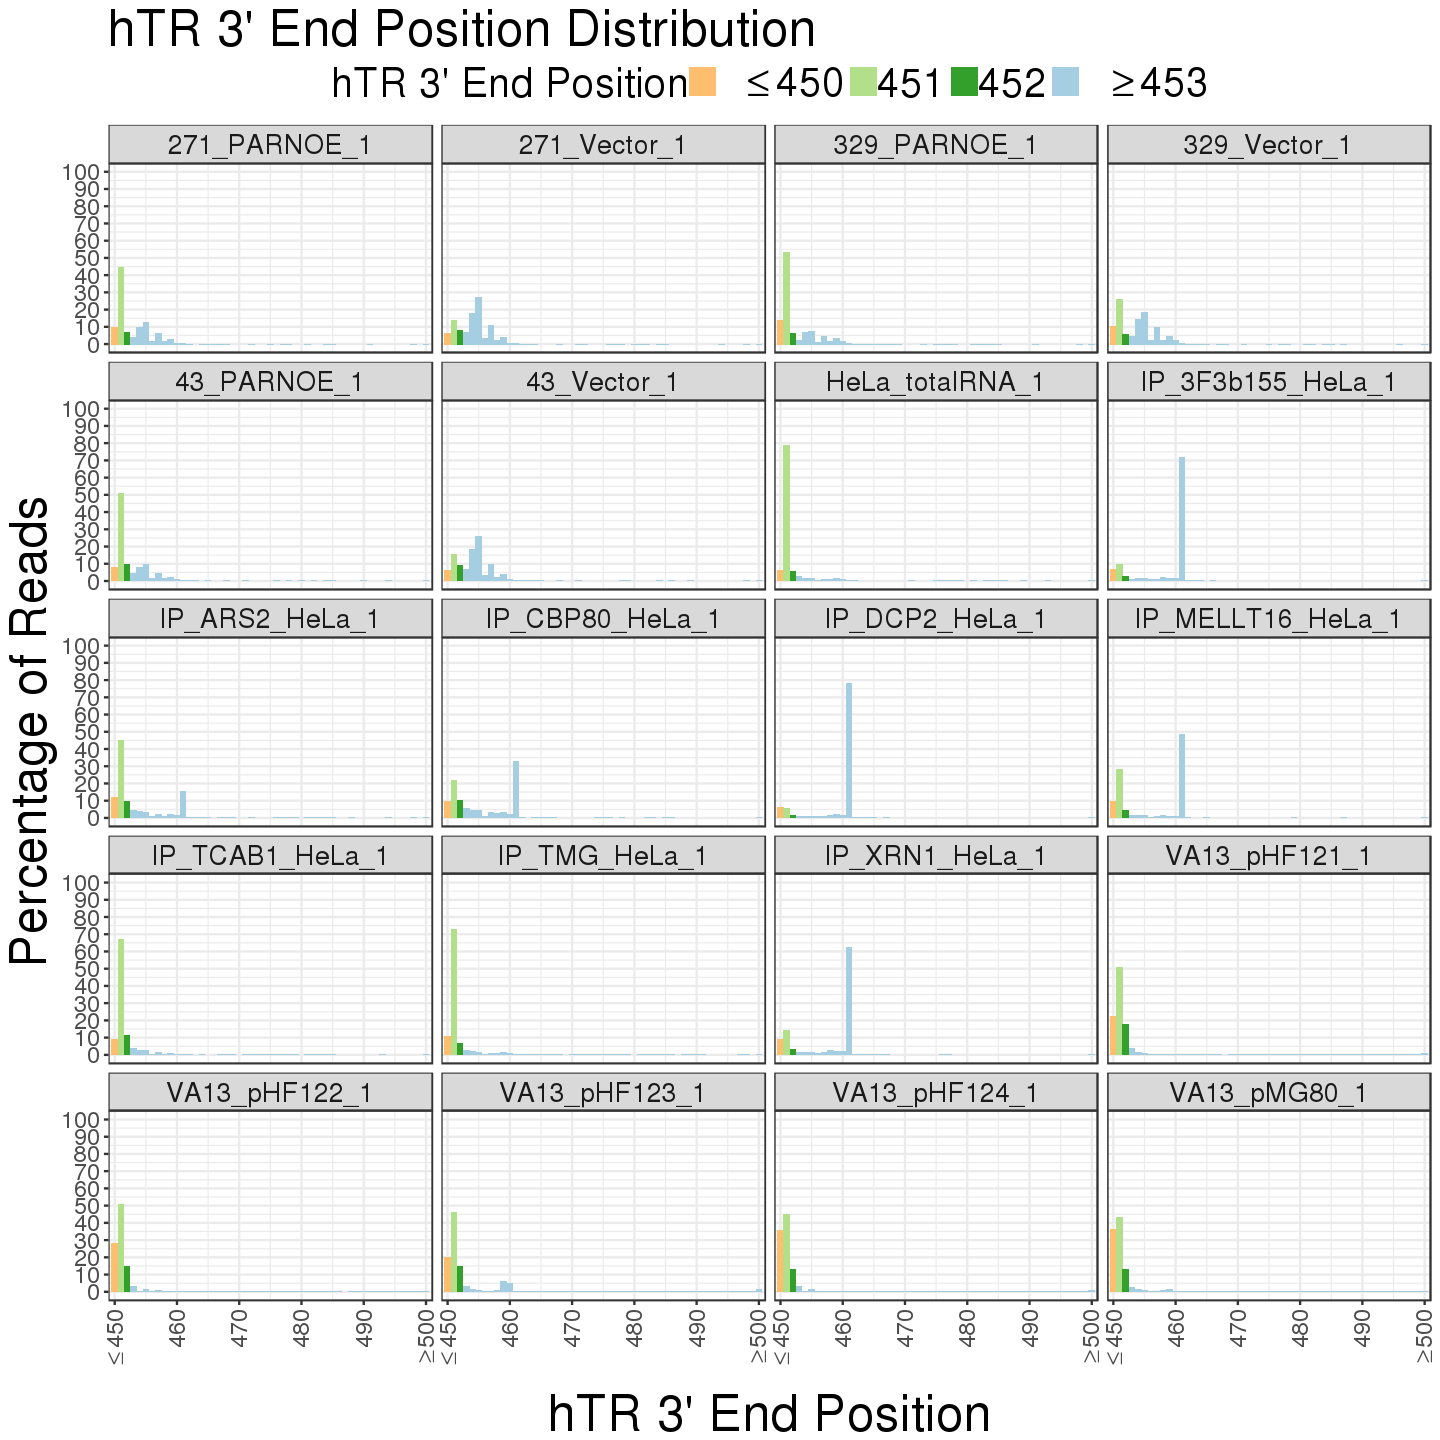

In [2]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "~/Projects/hui-fang/MOLNG-2232/processed_data/all_samples.tsv",
                   header = FALSE, 
                   sep = "\t")
# name cols
colnames(data) <- c('ntna', 'hTR_end', 'reads', 
                    'perc_reads', 'tota_reads', 'sample')

################## bin data in groups <= 450, 451, 452 & >=453 ##################
sub_450 <- subset(data, data$hTR_end <= 450.0)
sub_450$bin <- rep("<=450", nrow(sub_450))
sub_450$hTR_end <- rep(450.0, nrow(sub_450))

sub_451 <- subset(data, data$hTR_end == 451.0)
sub_451$bin <- rep("451", nrow(sub_451))
sub_452 <- subset(data, data$hTR_end == 452.0)
sub_452$bin <- rep("452", nrow(sub_452))

sub_453 <- subset(data, data$hTR_end >= 453.0 & data$hTR_end < 500.0)
sub_453$bin <- rep(">=453", nrow(sub_453))

sub_500 <- subset(data, data$hTR_end >= 500.0)
sub_500$bin <- rep(">=453", nrow(sub_500))
sub_500$hTR_end <- rep(500.0, nrow(sub_500))

bin_data <- rbind(sub_450, sub_451, sub_452, sub_453, sub_500)
#####################################################################################

# plot dataframe
g <- ggplot(bin_data, 
            aes(x = hTR_end, 
                y = perc_reads, 
                fill = as.factor(bin))) + 
            geom_bar(stat = 'identity') +
            theme_bw() +
            scale_y_continuous(expand = waiver(), 
                               limits = c(0, 100), 
                               breaks = seq(0,100,10)) +
            scale_x_continuous(expand = c(0,0), 
                               limits = c(449,501), 
                               breaks = seq(450, 500, 10), 
                               labels = c(expression(phantom(x)<= 450), 
                                          "460", "470", "480", "490", 
                                          expression(phantom(x)>= 500))) +
            ggtitle("hTR 3' End Position Distribution") +
            xlab("hTR 3' End Position") + ylab("Percentage of Reads") +
            theme(plot.title   = element_text(size=30),
                  axis.text.x  = element_text(size=14, 
                                              angle = 90, 
                                              vjust = 0.5, 
                                              hjust = 1),
                  axis.text.y  = element_text(size=14),
                  axis.title.x = element_text(size=30),
                  axis.title.y = element_text(size=30),
                  strip.text   = element_text(size=16),
                  legend.text  = element_text(size=24),
                  legend.title = element_text(size=24),
                   legend.key  = element_blank(),
                 legend.position='top') +
            scale_fill_manual(name="hTR 3' End Position",
                            values=c("<=450" = "#FDBF6F", 
                                     "451"   = "#B2DF8A",
                                     "452"   = "#33A02C", 
                                     ">=453" = "#A6CEE3"),
                            labels=c(expression(phantom(x)<= 450),  
                                     "451", "452", 
                                     expression(phantom(x)>= 453)),
                             breaks=c("<=450", "451", "452", ">=453")) +
            facet_wrap(~sample, ncol = 4)

# save figure
#ggsave(g, 
#       file="./fig/all_samples_facet_hTR_end_dist.pdf",
#       width = 12, height = 12)

g

>**In the figure above, we compare the hTR ending position in knock out samples to the control. The mature form of hTR ends at position 451, and this dominant population of hTR in the control sample. If there is an increase in the precursor population of hTR (>= 453) or premature form (<= 450) we can determine where in the RNA processing and degradation mechanism these knock out samples fit in.** 

## Identify & Plot distribution of polyA tails

### Identify polyA tails

In [ ]:
%%bash
# prepare output directories
mkdir -p ./spreadsheets/A_dist_df_10percNonA/
mkdir -p ./A_dist_df_10percNonA/
mkdir -p ./fig/A_dist_df_10percNonA

In [2]:
def get_A_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a polyA tail. It returns a dictionary where 
    the key is a tuple of:
        (polyA ntna sequene, lenght of the polyA sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyA definitions to choose from are:
        (1) pure polyA (no other nt present)
        (2) polyA sequence allowing 10% non-As (to accound for sequencing error or a
    sloppy poly-A polymerase adding non-As). This threshold can easily be changed to allow 
    any percent deviation from pure polyA. This threshold only takes effect when the polyA sequence
    is at least 10nt. So an ntna sequence with 9 As and 1 non-A will get counted.
    """
    # key = (polyA ntna seq, len, end pos), val = reads
    dist_A_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_A = ['C','G','T'] # this is for computing the 10% non-A

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all A's in ntna seq
                    pure_A = map(lambda x: x in ntna, not_A) # checks ntna sequence if all As, if so returns True
                    if True in pure_A: # if there is a pure polyA sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads)
                        dist_A_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-A in ntna seq
                    non_A = sum(y != 'A' for y in ntna) # count how many times a non-A seq is found in the ntna
                    if float(non_A)/float(len(ntna)) <= 0.1: # non-A seq divided by the total length of the seq 
                                                             # give the fraction of non-A's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads)
                        dist_A_dict[key] += reads
            elif len(ntna) == 0 and end_pos == 452:
                dist_A_dict[('A', 1, '451', total_reads)] += reads
            
    return dist_A_dict

In [3]:
def make_A_dist_df(A_dist_dict, sample):
    """ this function converts your A_dist_dict into a dataframe for saving"""
    
    df = pandas.DataFrame(columns=('len_A', 'hTR_end', 'perc_reads')) # initialize dataframe
   
    for key, val in A_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100] # keep length of polyA seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            df = df.append(pandas.Series(h, index = ['len_A', 'hTR_end', 'perc_reads']), 
                           ignore_index=True)
    
    return df

In [ ]:
path = "./ntna_dict_BCFILTER/"

for sample in os.listdir(path): # for each sample
    A_dist = get_A_dist(path + sample, 'allow_10%_non') # call the get_A_dist function with polyA threshold allowing 10% nonA
    df_A = make_A_dist_df(A_dist, sample) # conver get_A_dist dict to dataframe
    sample = re.split('_1', re.split(r'[.]', sample)[0])[0] # grab the sample name
    out_file = "./processed_data/A_dist_df_10percNonA/" + sample + ".csv" # outfile named by sample
    df_A.to_csv(out_file, index = False) # save dataframe as csv
    
    # save as excel spreadsheet, each sample will be a differnt tab
    writer = pandas.ExcelWriter('./spreadsheets/A_dist_df_10percNonA/' + sample + '.xlsx')
    df_A.to_excel(writer, sample)
    writer.save()

In [5]:
############## testing get_A_dist function #################

path = "./ntna_dict_BCFILTER/"
sample = "HeLa_totalRNA_1.tsv"
A_dist = get_A_dist(path + sample, 'allow_10%_non')
A_dist

Counter({('A', 1, '451', 616426): 16802,
         ('A', 1, '452', 616426): 5511,
         ('A', 1, '453', 616426): 555,
         ('A', 1, '<=450', 616426): 3020,
         ('A', 1, '>=454', 616426): 7394,
         ('AA', 2, '452', 616426): 2521,
         ('AA', 2, '453', 616426): 1335,
         ('AA', 2, '<=450', 616426): 744,
         ('AA', 2, '>=454', 616426): 3766,
         ('AAA', 3, '452', 616426): 2226,
         ('AAA', 3, '453', 616426): 1413,
         ('AAA', 3, '<=450', 616426): 491,
         ('AAA', 3, '>=454', 616426): 3462,
         ('AAAA', 4, '452', 616426): 2042,
         ('AAAA', 4, '453', 616426): 1901,
         ('AAAA', 4, '<=450', 616426): 163,
         ('AAAA', 4, '>=454', 616426): 3579,
         ('AAAAA', 5, '452', 616426): 1707,
         ('AAAAA', 5, '453', 616426): 1736,
         ('AAAAA', 5, '<=450', 616426): 222,
         ('AAAAA', 5, '>=454', 616426): 2426,
         ('AAAAAA', 6, '452', 616426): 1171,
         ('AAAAAA', 6, '453', 616426): 1552,
         ('AAA

### Plot polyA tail distribution

In [ ]:
%%bash

for i in ./A_dist_df_10percNonA/*.csv; do cat $i | grep -v "len_A" | sed "s/$/,$(basename $i .csv)/" >> ./A_dist_df_10percNonA/all_samples.csv; done

In [1]:
## start R kernel
library(ggplot2)
library(RColorBrewer)

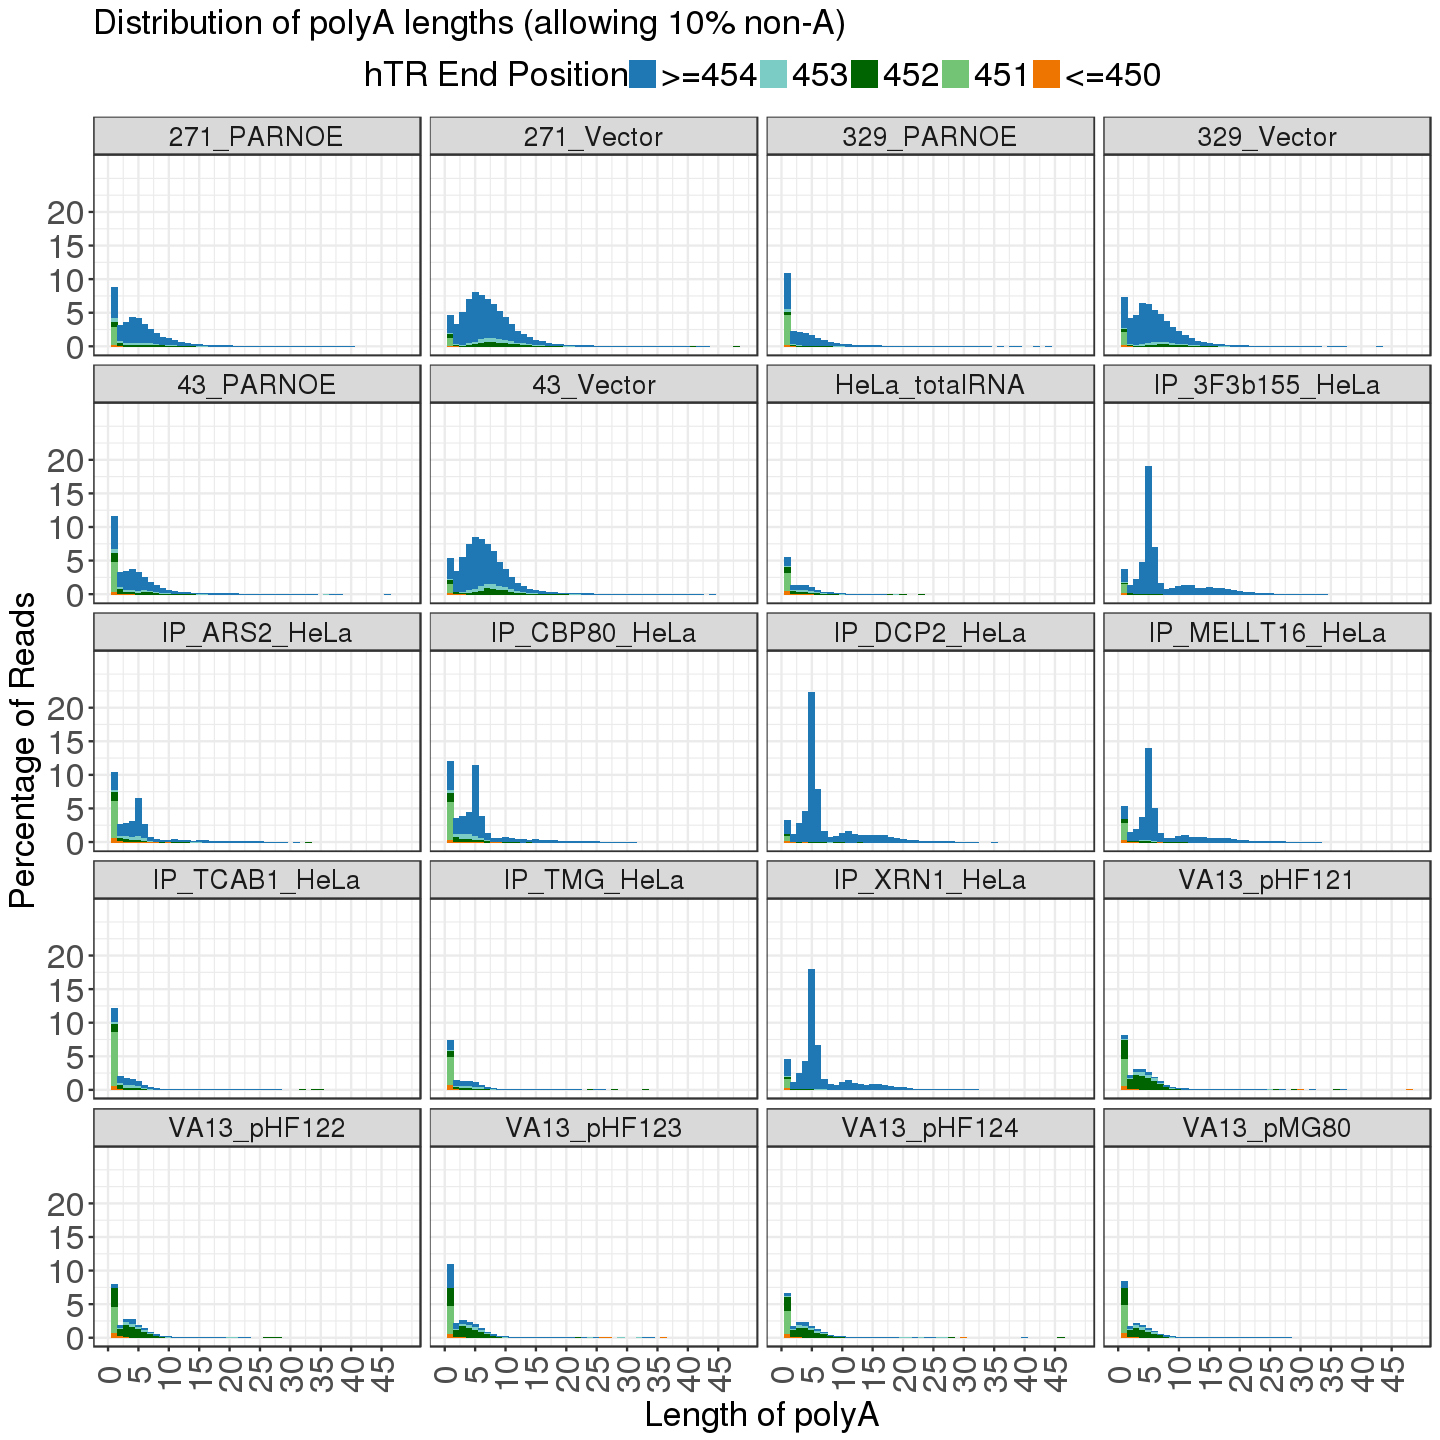

In [4]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "~/Projects/hui-fang/MOLNG-2232/processed_data/A_dist_df_10percNonA/all_samples.csv",
                   header = FALSE, 
                   sep = ",")
# name cols
colnames(data) <- c('len_A', 'hTR_end', 'perc_reads', 'sample')

###################### bin data in groups <= 450, 451, 452, 453 & >=454 ######################
data_450 <- subset(data, data$hTR_end == "<=450")
data_451 <- subset(data, hTR_end == "451")
data_452 <- subset(data, hTR_end == "452")
data_453 <- subset(data, data$hTR_end == "453")
data_454 <- subset(data, data$hTR_end == ">=454")
data_bins <- rbind(data_450, data_451, data_452, data_453, data_454)
data_bins$hTR_end <- factor(data_bins$hTR_end, 
                            levels = rev(c("<=450", '451', '452', '453', ">=454")))
################################################################################################

# plot dataframe
g <- ggplot(data_bins, 
            aes(x    = len_A, 
                y    = perc_reads, 
                fill = hTR_end)) + 

        geom_bar(width    = 1, 
                 stat     = 'identity', 
                 alpha    = 1, 
                 position = 'stack') +
        
        scale_y_continuous(limits = c(0, max(data_bins$perc_reads)+5), 
                           breaks = seq(0, max(data_bins$perc_reads), 5))+
        scale_x_continuous(limits = c(0,max(data_bins$len_A)), 
                           breaks = seq(0, max(data_bins$len_A), 5))+

        ggtitle("Distribution of polyA lengths (allowing 10% non-A)")+
        xlab("Length of polyA") + ylab("Percentage of Reads") +
        scale_fill_manual(name = "hTR End Position",
                          values = rev(c("darkorange2", "#74c476", 
                                         "DarkGreen", "#7BCCC4", "#1F78B4")))+
        theme_bw()+
        theme(plot.title   = element_text(size = 20),
              axis.text.x  = element_text(size = 20, 
                                          angle = 90, 
                                          vjust = 0.5),
              axis.text.y  = element_text(size = 20),
              axis.title.x = element_text(size = 20),
              axis.title.y = element_text(size = 20),
              strip.text   = element_text(size = 16),
              legend.text  = element_text(size = 20),
              legend.title = element_text(size = 20),
              legend.key   = element_blank(),
              legend.position = 'top') +
            facet_wrap(~sample, ncol = 4)

# save fig
#ggsave(file="./fig/A_dist_df_10percNonA/all_samples_polyA_len_stack.pdf", 
#       g, width = 14, height = 14)
g